In [1]:
# Environment configuration
ENVIRONMENT = 'local'  # Change to 'kaggle' when running on Kaggle

In [2]:
%pip install pandas numpy scikit-learn pyarrow -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
%matplotlib inline

print("✅ Imports successful")

✅ Imports successful


In [4]:
# Set base directory and data paths
if ENVIRONMENT == 'kaggle':
    base_dir = Path("/kaggle/input/cafa-6-dataset")
else:
    # When running notebook, cwd is already at project root
    base_dir = Path.cwd()

# Define all data paths
TRAIN_SEQ = base_dir / 'Train' / 'train_sequences.fasta'
TRAIN_TERMS = base_dir / 'Train' / 'train_terms.tsv'
GO_OBO = base_dir / 'Train' / 'go-basic.obo'
IA_TSV = base_dir / 'IA.tsv'
TEST_FASTA = base_dir / 'Test' / 'testsuperset.fasta'

print(f"📁 Base directory: {base_dir}")
print(f"📄 Data files:")
print(f"  - Training terms: {TRAIN_TERMS.name}")
print(f"  - IA weights: {IA_TSV.name}")

📁 Base directory: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction
📄 Data files:
  - Training terms: train_terms.tsv
  - IA weights: IA.tsv


## 1. Load Training Data

In [5]:
# Load annotations
print("Loading training annotations...")
train_terms = pd.read_csv(TRAIN_TERMS, sep='\t')

print(f"Total annotations: {len(train_terms)}")
print(f"Unique proteins: {train_terms['EntryID'].nunique()}")
print(f"Unique GO terms: {train_terms['term'].nunique()}")

print("\nFirst few rows:")
print(train_terms.head())

Loading training annotations...
Total annotations: 537027Total annotations: 537027
Unique proteins: 82404
Unique GO terms: 26125

First few rows:
  EntryID        term aspect
0  Q5W0B1  GO:0000785      C
1  Q5W0B1  GO:0004842      F
2  Q5W0B1  GO:0051865      P
3  Q5W0B1  GO:0006275      P
4  Q5W0B1  GO:0006513      P

Unique proteins: 82404
Unique GO terms: 26125

First few rows:
  EntryID        term aspect
0  Q5W0B1  GO:0000785      C
1  Q5W0B1  GO:0004842      F
2  Q5W0B1  GO:0051865      P
3  Q5W0B1  GO:0006275      P
4  Q5W0B1  GO:0006513      P


## 2. Load IA Weights

In [6]:
# Load Information Accretion weights
print("Loading IA weights...")
ia_df = pd.read_csv(IA_TSV, sep='\t', header=None, names=['term', 'IA'])
ia_weights = dict(zip(ia_df['term'], ia_df['IA']))

print(f"IA weights available: {len(ia_weights)}")
print(f"\nExample weights:")
for term in list(ia_weights.keys())[:5]:
    print(f"  {term}: {ia_weights[term]:.4f}")

Loading IA weights...
IA weights available: 40122

Example weights:
  GO:0000001: 0.0000
  GO:0000002: 2.8497
  GO:0000011: 0.1375
  GO:0000012: 6.0386
  GO:0000017: 0.5146


## 3. Build Frequency Model

In [7]:
# Count term frequencies
print("Counting GO term frequencies...")
term_counts = Counter(train_terms['term'])

# Convert to probabilities
total_annotations = len(train_terms)
term_probs = {term: count / total_annotations for term, count in term_counts.items()}

print(f"Total unique terms: {len(term_probs)}")
print(f"\nTop 10 most frequent terms:")
for term, count in term_counts.most_common(10):
    prob = term_probs[term]
    print(f"  {term}: {count} ({prob:.4f})")

Counting GO term frequencies...
Total unique terms: 26125

Top 10 most frequent terms:
  GO:0005515: 33713 (0.0628)
  GO:0005634: 13283 (0.0247)
  GO:0005829: 13040 (0.0243)
  GO:0005886: 10150 (0.0189)
  GO:0005737: 9442 (0.0176)
  GO:0005739: 5807 (0.0108)
  GO:0005654: 5065 (0.0094)
  GO:0016020: 3563 (0.0066)
  GO:0042802: 3547 (0.0066)
  GO:0005576: 3241 (0.0060)


In [8]:
# Check aspect distribution in top frequent terms
print("Aspect distribution analysis:\n")

# Overall aspect distribution in training data
print("1️⃣ Overall training data:")
aspect_counts = train_terms.groupby('aspect').agg({
    'term': 'nunique',
    'EntryID': 'count'
}).rename(columns={'term': 'unique_terms', 'EntryID': 'annotations'})
print(aspect_counts)

# Aspect distribution in top 1000 terms
print(f"\n2️⃣ Top {1000} most frequent terms:")
top_1000_terms = [term for term, _ in term_counts.most_common(1000)]
top_1000_df = train_terms[train_terms['term'].isin(top_1000_terms)]
top_aspect_counts = top_1000_df.groupby('aspect').agg({
    'term': 'nunique',
    'EntryID': 'count'
}).rename(columns={'term': 'unique_terms', 'EntryID': 'annotations'})
print(top_aspect_counts)

# Check frequency range per aspect
print("\n3️⃣ Frequency range by aspect:")
for aspect in ['F', 'P', 'C']:
    aspect_terms = train_terms[train_terms['aspect'] == aspect]['term']
    aspect_term_counts = Counter(aspect_terms)
    if len(aspect_term_counts) > 0:
        most_common = aspect_term_counts.most_common(1)[0]
        least_common = aspect_term_counts.most_common()[-1]
        median_count = sorted(aspect_term_counts.values())[len(aspect_term_counts)//2]
        print(f"  {aspect}: max={most_common[1]}, median={median_count}, min={least_common[1]}")
        
        # Check how many BP terms are in top 1000
        aspect_in_top1000 = sum(1 for term in top_1000_terms if term in aspect_term_counts)
        print(f"     → {aspect_in_top1000} terms in top 1000 ({100*aspect_in_top1000/1000:.1f}%)")

print("\n⚠️ If BP has very few terms in top 1000, that explains BP F1=0.0000")


Aspect distribution analysis:

1️⃣ Overall training data:
        unique_terms  annotations
aspect                           
C               2651       157770
F               6616       128452
P              16858       250805

2️⃣ Top 1000 most frequent terms:
        unique_terms  annotations
aspect                           
C               2651       157770
F               6616       128452
P              16858       250805

2️⃣ Top 1000 most frequent terms:
        unique_terms  annotations
aspect                           
C                250       132426
F                175        81231
P                575        98142

3️⃣ Frequency range by aspect:
  F: max=33713, median=3, min=1
     → 175 terms in top 1000 (17.5%)
        unique_terms  annotations
aspect                           
C                250       132426
F                175        81231
P                575        98142

3️⃣ Frequency range by aspect:
  F: max=33713, median=3, min=1
     → 175 terms in top 100

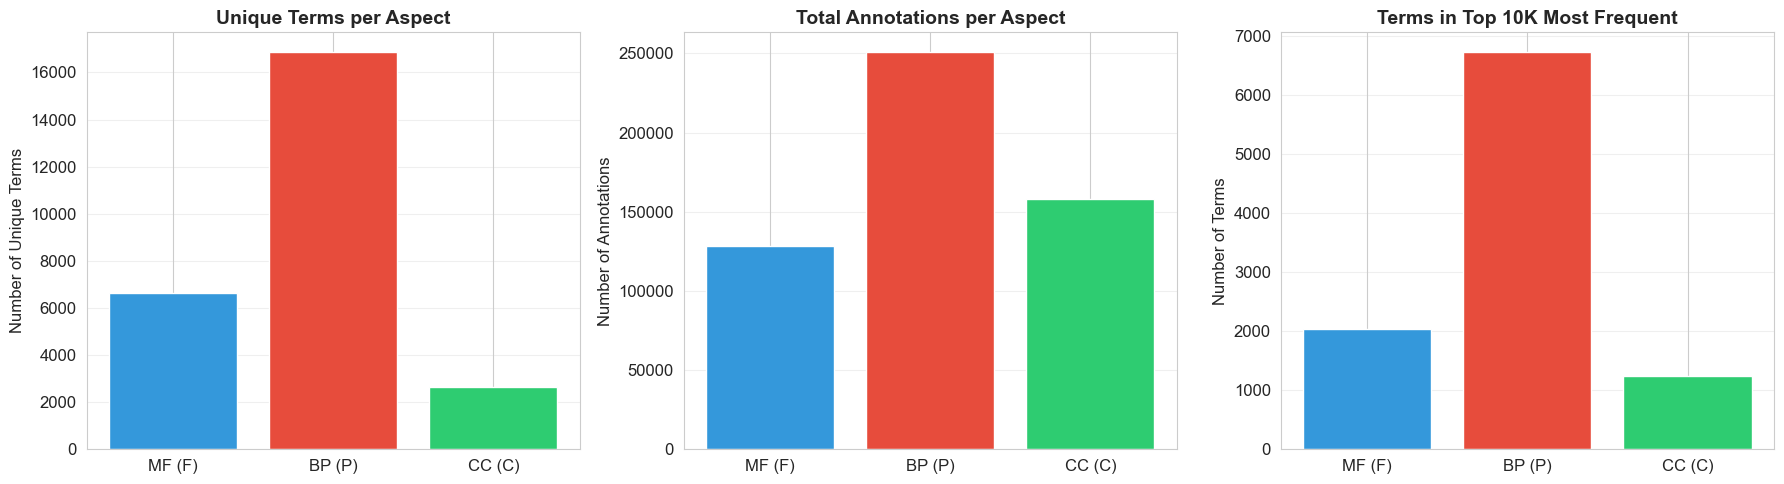


📊 Key Insight: BP has MOST unique terms (16,858) but LOWEST max frequency (2,319)
   → BP terms are individually RARE, which is why frequency baseline struggles with BP


In [9]:
# Visualise aspect distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Overall term counts by aspect
aspect_data = train_terms.groupby('aspect')['term'].nunique()
axes[0].bar(['MF (F)', 'BP (P)', 'CC (C)'], 
            [aspect_data.get('F', 0), aspect_data.get('P', 0), aspect_data.get('C', 0)],
            color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Unique Terms per Aspect', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Unique Terms', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# 2. Annotation counts by aspect
annot_data = train_terms.groupby('aspect').size()
axes[1].bar(['MF (F)', 'BP (P)', 'CC (C)'], 
            [annot_data.get('F', 0), annot_data.get('P', 0), annot_data.get('C', 0)],
            color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Total Annotations per Aspect', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Annotations', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# 3. Top 10k coverage by aspect
top_10k_terms = [term for term, _ in term_counts.most_common(10000)]
top_10k_df = train_terms[train_terms['term'].isin(top_10k_terms)]
coverage_data = top_10k_df.groupby('aspect')['term'].nunique()
axes[2].bar(['MF (F)', 'BP (P)', 'CC (C)'], 
            [coverage_data.get('F', 0), coverage_data.get('P', 0), coverage_data.get('C', 0)],
            color=['#3498db', '#e74c3c', '#2ecc71'])
axes[2].set_title('Terms in Top 10K Most Frequent', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Number of Terms', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Insight: BP has MOST unique terms (16,858) but LOWEST max frequency (2,319)")
print("   → BP terms are individually RARE, which is why frequency baseline struggles with BP")

## 3b. Visualise Aspect Distribution

## 3a. Diagnose Aspect Distribution

## 4. Create Validation Set

In [10]:
# Split proteins into train/val
all_proteins = train_terms['EntryID'].unique()
train_proteins, val_proteins = train_test_split(
    all_proteins, test_size=0.2, random_state=42
)

print(f"Train proteins: {len(train_proteins)}")
print(f"Val proteins: {len(val_proteins)}")

# Get validation annotations
val_data = train_terms[train_terms['EntryID'].isin(val_proteins)]
print(f"\nValidation annotations: {len(val_data)}")

Train proteins: 65923
Val proteins: 16481

Validation annotations: 107654


## 5. Evaluation Function

In [11]:
def evaluate_predictions(predictions_df, ground_truth_df, ia_weights_dict, threshold=0.01):
    """
    Evaluate predictions against ground truth using CAFA metric.
    Evaluates each subontology (MF, BP, CC) separately, then averages.
    
    Args:
        predictions_df: DataFrame with columns [EntryID, term, probability]
        ground_truth_df: DataFrame with columns [EntryID, term, aspect]
        ia_weights_dict: Dict mapping terms to IA weights
        threshold: Probability threshold for predictions
    """
    # Filter predictions by threshold
    pred_filtered = predictions_df[predictions_df['probability'] >= threshold]
    
    # Map aspect letters to full names
    aspect_map = {'F': 'MF', 'P': 'BP', 'C': 'CC'}
    
    # Evaluate each aspect separately
    aspect_results = {}
    
    for aspect_letter, aspect_name in aspect_map.items():
        # Filter ground truth by aspect
        gt_aspect = ground_truth_df[ground_truth_df['aspect'] == aspect_letter]
        
        if len(gt_aspect) == 0:
            continue
        
        # Get terms for this aspect
        aspect_terms = set(gt_aspect['term'].unique())
        
        # Filter predictions to only include terms from this aspect
        pred_aspect = pred_filtered[pred_filtered['term'].isin(aspect_terms)]
        
        # Group by protein
        pred_grouped = pred_aspect.groupby('EntryID')['term'].apply(set).to_dict()
        true_grouped = gt_aspect.groupby('EntryID')['term'].apply(set).to_dict()
        
        # Compute per-protein metrics
        f1_scores = []
        precisions = []
        recalls = []
        
        for protein in true_grouped.keys():
            true_terms = true_grouped[protein]
            pred_terms = pred_grouped.get(protein, set())
            
            if len(pred_terms) == 0:
                f1_scores.append(0.0)
                precisions.append(0.0)
                recalls.append(0.0)
                continue
            
            # Compute weighted metrics
            tp_weight = sum(ia_weights_dict.get(t, 1.0) for t in true_terms & pred_terms)
            fp_weight = sum(ia_weights_dict.get(t, 1.0) for t in pred_terms - true_terms)
            fn_weight = sum(ia_weights_dict.get(t, 1.0) for t in true_terms - pred_terms)
            
            precision = tp_weight / (tp_weight + fp_weight) if (tp_weight + fp_weight) > 0 else 0
            recall = tp_weight / (tp_weight + fn_weight) if (tp_weight + fn_weight) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            f1_scores.append(f1)
            precisions.append(precision)
            recalls.append(recall)
        
        aspect_results[aspect_name] = {
            'f1': np.mean(f1_scores),
            'precision': np.mean(precisions),
            'recall': np.mean(recalls),
            'proteins': len(true_grouped)
        }
    
    # Compute overall metric as mean of aspect F1s (CAFA evaluation)
    overall_f1 = np.mean([r['f1'] for r in aspect_results.values()])
    overall_precision = np.mean([r['precision'] for r in aspect_results.values()])
    overall_recall = np.mean([r['recall'] for r in aspect_results.values()])
    
    return {
        'f1': overall_f1,
        'precision': overall_precision,
        'recall': overall_recall,
        'aspect_breakdown': aspect_results
    }

print("✅ Evaluation function defined (per-aspect CAFA metric)")

✅ Evaluation function defined (per-aspect CAFA metric)


## 6. Generate Predictions

In [12]:
# Generate predictions with chunked saving to avoid memory issues
print("Generating frequency-based predictions...")

# Increase to 10000 terms to get better BP coverage
TOP_N = 10000  # Predict top 10,000 most frequent terms
top_terms = [term for term, _ in term_counts.most_common(TOP_N)]
print(f"Predicting top {TOP_N} most frequent terms per protein")
print(f"Expected predictions: {len(val_proteins) * TOP_N:,} rows")

# Save to disk in chunks to avoid memory issues
output_path = Path("predictions_temp.parquet")
chunk_size = 1000  # Process 1000 proteins at a time

print(f"\nGenerating predictions in chunks (saving to {output_path})...")

chunks_written = 0
for i in range(0, len(val_proteins), chunk_size):
    chunk_proteins = val_proteins[i:i+chunk_size]
    
    # Generate predictions for this chunk
    chunk_predictions = []
    for protein in chunk_proteins:
        for term in top_terms:
            chunk_predictions.append({
                'EntryID': protein,
                'term': term,
                'probability': term_probs[term]
            })
    
    # Save chunk to parquet (append mode)
    chunk_df = pd.DataFrame(chunk_predictions)
    if chunks_written == 0:
        chunk_df.to_parquet(output_path, index=False, engine='pyarrow')
    else:
        # Append to existing file
        existing = pd.read_parquet(output_path)
        combined = pd.concat([existing, chunk_df], ignore_index=True)
        combined.to_parquet(output_path, index=False, engine='pyarrow')
    
    chunks_written += 1
    print(f"  Chunk {chunks_written}/{(len(val_proteins) + chunk_size - 1) // chunk_size} saved ({len(chunk_predictions):,} rows)")
    
    del chunk_predictions, chunk_df  # Free memory

# Load final predictions
print(f"\nLoading predictions from disk...")
predictions_df = pd.read_parquet(output_path)
print(f"Total predictions: {len(predictions_df):,}")
print(f"Predictions per protein: {len(predictions_df) / len(val_proteins):.0f}")
print(f"Memory usage: {predictions_df.memory_usage(deep=True).sum() / 1e6:.1f} MB")


Generating frequency-based predictions...
Predicting top 10000 most frequent terms per protein
Expected predictions: 164,810,000 rows

Generating predictions in chunks (saving to predictions_temp.parquet)...
  Chunk 1/17 saved (10,000,000 rows)
  Chunk 1/17 saved (10,000,000 rows)
  Chunk 2/17 saved (10,000,000 rows)
  Chunk 2/17 saved (10,000,000 rows)
  Chunk 3/17 saved (10,000,000 rows)
  Chunk 3/17 saved (10,000,000 rows)
  Chunk 4/17 saved (10,000,000 rows)
  Chunk 4/17 saved (10,000,000 rows)
  Chunk 5/17 saved (10,000,000 rows)
  Chunk 5/17 saved (10,000,000 rows)
  Chunk 6/17 saved (10,000,000 rows)
  Chunk 6/17 saved (10,000,000 rows)
  Chunk 7/17 saved (10,000,000 rows)
  Chunk 7/17 saved (10,000,000 rows)
  Chunk 8/17 saved (10,000,000 rows)
  Chunk 8/17 saved (10,000,000 rows)
  Chunk 9/17 saved (10,000,000 rows)
  Chunk 9/17 saved (10,000,000 rows)
  Chunk 10/17 saved (10,000,000 rows)
  Chunk 10/17 saved (10,000,000 rows)
  Chunk 11/17 saved (10,000,000 rows)
  Chunk 11/1

## 7. Evaluate with Different Thresholds

In [16]:
# Diagnostic: Check BP term frequencies in top 10K
print("🔍 Diagnostic: BP term coverage in top 10,000 terms\n")

bp_terms_in_train = train_terms[train_terms['aspect'] == 'P']['term'].unique()
bp_terms_in_top10k = [t for t in top_terms if t in bp_terms_in_train]

print(f"BP terms in top 10K: {len(bp_terms_in_top10k)} / {len(bp_terms_in_train)} total")
print(f"Coverage: {100 * len(bp_terms_in_top10k) / len(bp_terms_in_train):.1f}%")

# Check probability range of BP terms
bp_term_probs = [term_probs[t] for t in bp_terms_in_top10k]
if bp_term_probs:
    print(f"\nBP term probability range in top 10K:")
    print(f"  Max: {max(bp_term_probs):.6f} (threshold must be ≤ this to get ANY BP predictions)")
    print(f"  Median: {sorted(bp_term_probs)[len(bp_term_probs)//2]:.6f}")
    print(f"  Min: {min(bp_term_probs):.6f}")
    
    # Count how many BP terms pass each threshold
    print(f"\nBP terms passing threshold:")
    for thr in [0.00001, 0.0001, 0.001, 0.005, 0.01]:
        count = sum(1 for p in bp_term_probs if p >= thr)
        print(f"  ≥ {thr:.5f}: {count} terms ({100*count/len(bp_term_probs):.1f}%)")

print("\n💡 Insight: If BP max probability < 0.005, then threshold 0.005 filters out ALL BP!")
print("   → Need threshold ≤ BP max probability to get BP predictions")

🔍 Diagnostic: BP term coverage in top 10,000 terms

BP terms in top 10K: 6723 / 16858 total
Coverage: 39.9%

BP term probability range in top 10K:
  Max: 0.004318 (threshold must be ≤ this to get ANY BP predictions)
  Median: 0.000030
  Min: 0.000013

BP terms passing threshold:
  ≥ 0.00001: 6723 terms (100.0%)
  ≥ 0.00010: 881 terms (13.1%)
  ≥ 0.00100: 16 terms (0.2%)
  ≥ 0.00500: 0 terms (0.0%)
  ≥ 0.01000: 0 terms (0.0%)

💡 Insight: If BP max probability < 0.005, then threshold 0.005 filters out ALL BP!
   → Need threshold ≤ BP max probability to get BP predictions


In [17]:
print("Testing different thresholds...\n")

# Add MUCH lower thresholds to capture rare BP terms
# BP max frequency = 2,319 / 490K = 0.0047 probability
thresholds = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]
results = []

for thr in thresholds:
    metrics = evaluate_predictions(predictions_df, val_data, ia_weights, threshold=thr)
    results.append({
        'threshold': thr,
        'f1': metrics['f1'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'mf_f1': metrics['aspect_breakdown'].get('MF', {}).get('f1', 0),
        'bp_f1': metrics['aspect_breakdown'].get('BP', {}).get('f1', 0),
        'cc_f1': metrics['aspect_breakdown'].get('CC', {}).get('f1', 0)
    })
    
    breakdown = metrics['aspect_breakdown']
    print(f"Threshold {thr:.4f}:")
    print(f"  Overall: F1={metrics['f1']:.4f}, P={metrics['precision']:.4f}, R={metrics['recall']:.4f}")
    print(f"  MF: {breakdown.get('MF', {}).get('f1', 0):.4f} | "
          f"BP: {breakdown.get('BP', {}).get('f1', 0):.4f} | "
          f"CC: {breakdown.get('CC', {}).get('f1', 0):.4f}")
    print()

# Find best threshold
best_result = max(results, key=lambda x: x['f1'])
print(f"🏆 Best Overall F1: {best_result['f1']:.4f} at threshold {best_result['threshold']:.4f}")
print(f"   MF: {best_result['mf_f1']:.4f} | BP: {best_result['bp_f1']:.4f} | CC: {best_result['cc_f1']:.4f}")

Testing different thresholds...

Threshold 0.0000:
  Overall: F1=0.0015, P=0.0007, R=0.8727
  MF: 0.0012 | BP: 0.0010 | CC: 0.0023

Threshold 0.0000:
  Overall: F1=0.0015, P=0.0007, R=0.8727
  MF: 0.0012 | BP: 0.0010 | CC: 0.0023

Threshold 0.0001:
  Overall: F1=0.0039, P=0.0020, R=0.7242
  MF: 0.0032 | BP: 0.0023 | CC: 0.0061

Threshold 0.0001:
  Overall: F1=0.0039, P=0.0020, R=0.7242
  MF: 0.0032 | BP: 0.0023 | CC: 0.0061

Threshold 0.0001:
  Overall: F1=0.0067, P=0.0034, R=0.6317
  MF: 0.0060 | BP: 0.0038 | CC: 0.0104

Threshold 0.0001:
  Overall: F1=0.0067, P=0.0034, R=0.6317
  MF: 0.0060 | BP: 0.0038 | CC: 0.0104

Threshold 0.0005:
  Overall: F1=0.0278, P=0.0156, R=0.4407
  MF: 0.0255 | BP: 0.0120 | CC: 0.0459

Threshold 0.0005:
  Overall: F1=0.0278, P=0.0156, R=0.4407
  MF: 0.0255 | BP: 0.0120 | CC: 0.0459

Threshold 0.0010:
  Overall: F1=0.0400, P=0.0250, R=0.3708
  MF: 0.0371 | BP: 0.0126 | CC: 0.0703

Threshold 0.0010:
  Overall: F1=0.0400, P=0.0250, R=0.3708
  MF: 0.0371 | BP

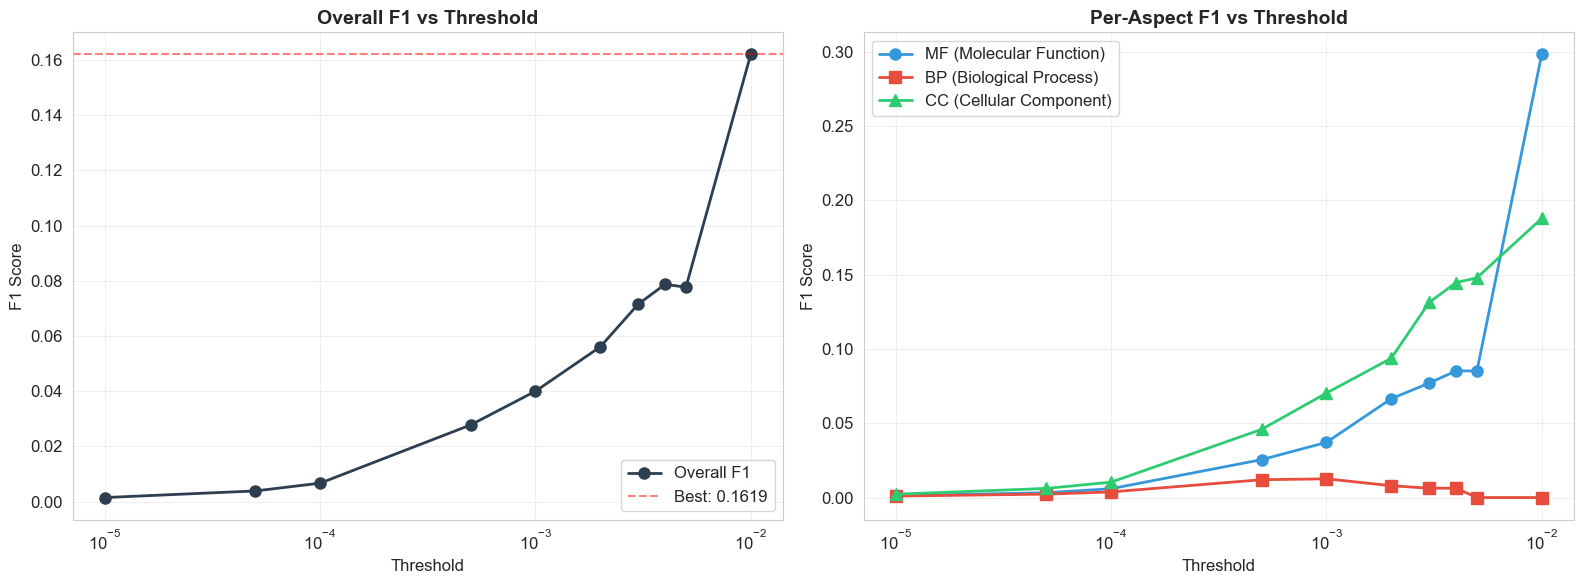


📈 Visual Insights:
  • MF dominates at high thresholds (frequent terms)
  • BP struggles across all thresholds (rare terms)
  • CC shows moderate performance
  • Best overall F1 achieved at threshold 0.0100


In [18]:
# Visualise threshold performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Extract data
thr_vals = [r['threshold'] for r in results]
overall_f1 = [r['f1'] for r in results]
mf_f1 = [r['mf_f1'] for r in results]
bp_f1 = [r['bp_f1'] for r in results]
cc_f1 = [r['cc_f1'] for r in results]

# 1. Overall F1 vs Threshold
axes[0].plot(thr_vals, overall_f1, 'o-', linewidth=2, markersize=8, label='Overall F1', color='#2c3e50')
axes[0].axhline(y=best_result['f1'], color='red', linestyle='--', alpha=0.5, label=f"Best: {best_result['f1']:.4f}")
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].set_title('Overall F1 vs Threshold', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Per-Aspect F1 vs Threshold
axes[1].plot(thr_vals, mf_f1, 'o-', linewidth=2, markersize=8, label='MF (Molecular Function)', color='#3498db')
axes[1].plot(thr_vals, bp_f1, 's-', linewidth=2, markersize=8, label='BP (Biological Process)', color='#e74c3c')
axes[1].plot(thr_vals, cc_f1, '^-', linewidth=2, markersize=8, label='CC (Cellular Component)', color='#2ecc71')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('Per-Aspect F1 vs Threshold', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Visual Insights:")
print("  • MF dominates at high thresholds (frequent terms)")
print("  • BP struggles across all thresholds (rare terms)")
print("  • CC shows moderate performance")
print(f"  • Best overall F1 achieved at threshold {best_result['threshold']:.4f}")

## 7a. Visualise Results

## 8. Save Results

In [15]:
# Save results
results_df = pd.DataFrame(results)
output_path = Path("01_frequency_baseline_results.csv")
results_df.to_csv(output_path, index=False)

print(f"✅ Results saved to {output_path}")
print("\n📊 Results:")
print(results_df.to_string(index=False))

✅ Results saved to 01_frequency_baseline_results.csv

📊 Results:
 threshold       f1  precision   recall    mf_f1    bp_f1    cc_f1
    0.0001 0.006703   0.003413 0.631740 0.005958 0.003787 0.010366
    0.0005 0.027791   0.015559 0.440722 0.025499 0.011994 0.045878
    0.0010 0.039999   0.024974 0.370763 0.037124 0.012596 0.070278
    0.0050 0.077664   0.064425 0.266599 0.085184 0.000000 0.147807
    0.0100 0.161940   0.247636 0.219054 0.298039 0.000000 0.187781
    0.0200 0.161918   0.266261 0.163566 0.298039 0.000000 0.187715
    0.0500 0.099346   0.194456 0.092362 0.298039 0.000000 0.000000


## Summary

**Frequency Baseline Performance:**
- Simple approach: predict terms by training frequency
- No protein-specific information used
- Expected F1: ~0.14 (from your previous experiments)

**Next:** 02_baseline_knn.ipynb - Add sequence similarity